<a href="https://colab.research.google.com/github/MarkStephens060482/MarkStephens060482/blob/main/MapReduce%2C_Similar_Items_and_Data_Streams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MapReduce, Similar Items and Data Streams

### Exercise 1 - Friend Recommendation System
A “People You Might Know” social network friendship 
recommendation algorithm.

The program uses a number of MapReduce process to achieve the outcome. The initial map tasks seperates the text elements per line at the tab delimiter and then at the comma delimeter, forming tuple elements of (User, [Friends]) pairs, where [Friends] is a list of actual friends. The permutations of each actual friends list per user are found and mapped and combined to key value pairs of mutual friends of the form *((friend_i, friend_j), 1)*. All tuple elements are reduced to total count of each unique mutual friend pair, achieving an resilient distributed dataset of key value elements of the form *((friend_i, friend_j), Value)*. These values are sorted by Value then by key to ensure the recommended friends list per user is prepared in dscending order of value. A reducer is used on the key value RDD to form a single tuple element per User consisting of a list of recommended friends for that User, of the form of *(User_i,[friend1,friend2,...,friend_n])*. This is then mapped to a sorted list of tuples by User and the list of recommended friends in truncated to 10 friends. The RDD is mapped to the format of a tab delimitered string per line and is saved as an output textfile. The recommendations for the users with user IDs of interest is as follows:

|User|Friend Recommendations |
|:---:|:---------------------:|
| 924|[45881, 43748, 15416, 11860, 6995, 2409, 439]|
|8941|[8938, 8946, 8942, 8945, 8944, 8943, 8939, 8940]|
|8942|[8941, 8939, 8938, 8946, 8945, 8944, 8943, 8940]|
|9019|[320, 9018, 9022, 9021, 9020, 9017, 9016, 9023, 317]|
|9020|[9021, 9022, 9019, 9018, 9017, 9016, 320, 9023, 317]|
|9021|[9020, 9022, 9019, 9018, 9017, 9016, 320, 9023, 317]|
|9022|[9021, 9020, 9019, 9023, 9018, 9017, 9016, 320, 317]|
|9990|[9994, 9993, 9989, 9988, 9987, 35667, 9991, 9992, 37941, 34642]|
|9992|[9989, 9987, 35667, 9994, 9993, 9990, 9988, 9991]|
|9993|[9994, 9990, 9991, 9989, 9988, 9987, 35667, 9992, 37941, 34642]|


Install Pyspark package

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the Google Drive to Google Collab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import relevant libraries from PySpark and initialise a Spark Session. The session is run in Standalone mode designated with 'local' using all available CPU cores.The Spark application name is set as *'Friends Recommendation'* and an existing SparkSession object is returned or a new one is created.

In [ ]:
# Create SparkSession and SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder\
                  .master('local[*]')\
                  .appName('FriendsRecommendation')\
                  .getOrCreate()
sc = spark.sparkContext

Load the input file of the adjacency list of *Users* and *Friends* per line, each represented by an unique integer ID. 

In [ ]:
input_PATH = '/content/gdrive/MyDrive/Colab Notebooks/soc-LiveJournal1Adj.txt'
adj = sc.textFile(input_PATH)

The function is to determine a list of mutual friend pairs and construct a (key, value) tuple in the form of ((friend1, friend2), 1). The mutual friend pairs takes into consideration that friendships are mutual, that is, if A is friends with B then B is friends with A. This implies that (1,2) is different from (2,1) and so are counted seperately.

In [ ]:
from itertools import permutations

# Unique Combination Pairs for list of elements
def mutualfriends(list_elements):
  friend_connections = []
  for pair in permutations(list_elements,2):
    friend_connections.append(pair)
  return friend_connections

Define a combiner to combine all mutual friend pairs. The *mapKeys* function returns a key-value tuple of the form ((friend1,friend2),1).The *createCombiner* function passes the key value tuple of  to the *combineByKey* function. The mergeValue


In [ ]:
# Defining createCombiner, mergeValue and mergeCombiner functions
def mapKeys(tuple):
   return (tuple,1)

def createCombiner(value):
  return value
    
def mergeValue(combiner, new_value): 
  return combiner + new_value
    
def mergeCombiner(combiner1, combiner2): 
  count = combiner1 + combiner2
  return count

This function returns a condition value n for the top N list of friend recommendations. If the list of friend recommendations is less than n, then the function returns the lenth of the recommendations list, otherwise it will return the top n value.

In [ ]:
def conditionaltopN(l,n):
  if len(l) < n:
    return len(l)
  return n

The main program consists of a series of MapReduce jobs that takes the input of < User >< TAB >< Friends > strings and maps it to tuples elements of mutual friends per user in the form of (Friend_i, Friend_j). Then a Combiner forms key value pairs and reduces the elements to ((Friend_i,Friend_j),Value) mutual friends elements. Key value tuple elements are sorted and reduced to (Friend_i, [friend1, friend2,...,friendn]) elements where list of friends are in descendinbg order of value. The elements are then mapped to (Friend_i, [friend1, friend2,...,friend10]) with a truncated list to 10 or less recommended friends.

In [ ]:
# *********The Main Program***********
if __name__ == "__main__":   
  #transform the adjacency list text file to split at the occurrences of a tab
  friend_data = adj.map(lambda line: line.split("\t"))
  # convert user and friends to a tuple with the friends as a list.  
  user_friendlist_tuples = friend_data.map(lambda x: (x[0],x[1].split(',')))
  # map the user_friendlist tuple pairs to a list of key value pairs, where the keys are mutual friend
  #pairings for each user. 
  mutualfriends_list = user_friendlist_tuples.flatMap(lambda x: mutualfriends((x[1])))
  # map the elements in the tuples from strings to integers.
  mutualfriends_integer_list = mutualfriends_list.map(lambda x: tuple(map(int,x)))
  # Counts the occurrences of each mutual friends tuple key.
  mutualfriendsCount = mutualfriends_integer_list.map(mapKeys)\
  .combineByKey(createCombiner,mergeValue,mergeCombiner)

  # sort the tuples of mutual friends first by the value,
  # then by the numerical value of the friend ID both in descending order.
  mutualfriendsCount_sorted = mutualfriendsCount.sortBy(lambda x: [x[1],x[0]], ascending = False)

  # map the mutual friend key value pairs to user and friend recommendation key value pair,
  # where the friend recommendation is a list of elements
  friend_recommendations = mutualfriendsCount_sorted.map(lambda x: (x[0][0],[ x[0][1] ]))\
  .reduceByKey(lambda a, b: a + b)

  # sort the tuples by user, then restrict the list of recommended friends to the top 10.  
  n = 10
  friend_recs_sorted_topn = friend_recommendations.sortBy(lambda x: x[0])\
  .map(lambda x: (x[0],x[1][:conditionaltopN(x[1],n)]))

  # Observe the top 5 elements of the RDD to confirm program has worked properly
  friend_recs_sorted_topn.take(5)

The key value RDD is filtered by the users of interest and presented in a dataframe. This is achieved by using the *RDD.filter()* function and *createDataFrame* function converts to the dataframe representation.

In [ ]:
# recommendations for the users with following user IDs: 924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993.
users_of_interest = [924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993]
selected_recommendations = friend_recs_sorted_topn.filter(lambda x: x[0] in users_of_interest)

schema_lst = ["User","Friend Recommendations"]
 
 # calling function to convert RDD to dataframe
selected_recommendations_df = spark.createDataFrame(selected_recommendations,schema_lst)
   
# visualizing the schema and dataframe
selected_recommendations_df.printSchema()
selected_recommendations_df.show(truncate=False)

root
 |-- User: long (nullable = true)
 |-- Friend Recommendations: array (nullable = true)
 |    |-- element: long (containsNull = true)

+----+---------------------------------------------------------------+
|User|Friend Recommendations                                         |
+----+---------------------------------------------------------------+
|924 |[45881, 43748, 15416, 11860, 6995, 2409, 439]                  |
|8941|[8938, 8946, 8942, 8945, 8944, 8943, 8939, 8940]               |
|8942|[8941, 8939, 8938, 8946, 8945, 8944, 8943, 8940]               |
|9019|[320, 9018, 9022, 9021, 9020, 9017, 9016, 9023, 317]           |
|9020|[9021, 9022, 9019, 9018, 9017, 9016, 320, 9023, 317]           |
|9021|[9020, 9022, 9019, 9018, 9017, 9016, 320, 9023, 317]           |
|9022|[9021, 9020, 9019, 9023, 9018, 9017, 9016, 320, 317]           |
|9990|[9994, 9993, 9989, 9988, 9987, 35667, 9991, 9992, 37941, 34642]|
|9992|[9989, 9987, 35667, 9994, 9993, 9990, 9988, 9991]              |
|9993|[99

The elements of the Resilient Distributed Dataset are prepare for the output by mapping them to tab seperated strings, of the form:
 * < User>< TAB>< Recommendations  > 

 The RDD is converted to a Binary File using the saveAsTextFile() method. This method writes the RDD data to a distributed file system (e.g., HDFS) in parallel, which can handle large data volumes and distribute the write operation across multiple nodes in a cluster, however the HDFS is coalesced to a single file called part-00000.

In [ ]:
# Produce the output in the format <User><TAB><Recommendations>
output = friend_recs_sorted_topn.map(lambda x: "%s\t%s" %(x[0],x[1]))

# define the directory where the partition files are located
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/output"

# write the RDD output to a HDFS coalesced to a single partition file.
output.coalesce(1,True).saveAsTextFile(dir_path)

The Binary File with name *part-00000* is converted to a textfile with extension .txt such that it may be read externally by any text file reader application.

In [ ]:
# import the os and shutil libraries
import os
import shutil

# loop over all files in the directory and rename them with the .txt extension
for filename in os.listdir(dir_path):
    if filename.startswith('part-'):
        os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, filename + '.txt'))

spark.stop()

***
# Exercise 2 - S-curve

Locality Sensitive Hashing (LSH) is a procedure that hashes similar input items into the same category of 'bucket' with high probability. It finds similar items without computing similarities between every possible pair. The MinHash Signature matrix of the Characteristic matrix of sets (documents), is divided up into **b** bands each with **r** rows. Also, suppose a particular pair of documents have Jaccard similarity **s**.Also, it is found that the probability the MinHash Signature for these documents are equal in any particular row of the signature matrix is also **s**. Therefore the probability that the signatures of the documents become candidate pairs from performing LSH is given by:

> >>$1-(1-s^r)^b$

That is, the probability that the signatures agree in all the rows of at least one band, and therefore become a candidate pair. When the probability is greater than 0.5, the *threshold* for the similarity of document pairs to be regarded as a desired "similar pair is estimated to be:
> >>$t = (1/b)^{1/a}$  

It is noted that this gives an over-estimate and is highlighted as a coordinate point on the plots below.

The code below defines the *S-curve* function with parameters *S*, *r* and *b*. The three cases of values for *r* and *b* are defined. The range of values of the Jaccard similarity *s* is also defined using numpy's *linspace* function. The values of probabilities determined by the S-curve function are evaluated for the specific parameters and are shown in the dataframe. A graphical represerntation of the three S-curves is provided with the threshold cooridnate annotated on the graphs.

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# define function for S-curve
def Scurve(s,r,b):
  p = 1-(1-s**r)**b
  return p

# define values of Jaccard Similarities
s = np.linspace(0,1,100, endpoint = False)

# parameters 
r1, b1 = 3,10
r2, b2 = 6,20
r3, b3 = 5,50

# define S-curve values
p1 = Scurve(s,r1,b1)
p2 = Scurve(s,r2,b2)
p3 = Scurve(s,r3,b3)

#dataframe of values
Scurve_df = pd.DataFrame(np.c_[s,p1,p2,p3],columns=["Jaccard Similarity",'r=3,b=10','r=6,b=20','r=5,b=50'])

# approximating the Threshold t = (1/b)^(1/r)
t1 = (1/b1)**(1/r1)
t2 = (1/b2)**(1/r2)
t3 = (1/b3)**(1/r3)

# The S-curve fuction is evaluated
Scurve_df.iloc[10:100:10, :]

,Jaccard Similarity,"r=3,b=10","r=6,b=20","r=5,b=50"
10,0.1,0.009955,0.000020,0.000500
20,0.2,0.077181,0.001279,0.015875
30,0.3,0.239449,0.014479,0.114540
40,0.4,0.483871,0.078809,0.402284
50,0.5,0.736924,0.270187,0.795551
60,0.6,0.912267,0.615415,0.982534
70,0.7,0.985015,0.918186,0.999899
80,0.8,0.999234,0.997712,1.000000
90,0.9,0.999998,1.000000,1.000000


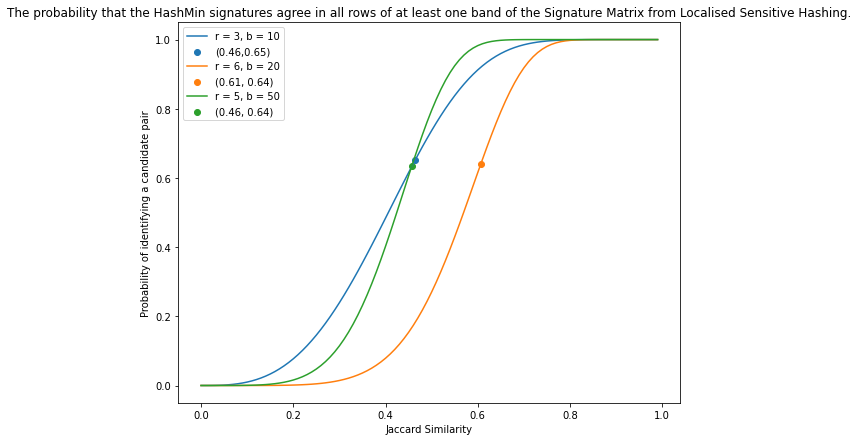

In [ ]:
# The graphical representation of the probability that signatures agree in all the rows of at least on band.
fig = plt.figure(figsize=(9,7))
# r = 3, b = 10
plt.plot(s,p1,label ='r = 3, b = 10')
plt.scatter(t1,Scurve(t1,r1,b1),label =f"({t1:.2f},{Scurve(t1,r1,b1):.2f})",marker="o")

# r = 6, b = 20
plt.plot(s,p2,label ='r = 6, b = 20')
plt.scatter(t2,Scurve(t2,r2,b2),label =f"({t2:.2f}, {Scurve(t2,r2,b2):.2f})",marker="o")
# r = 5, b = 50
plt.plot(s,p3,label ='r = 5, b = 50')
plt.scatter(t3,Scurve(t3,r3,b3),label =f"({t3:.2f}, {Scurve(t3,r3,b3):.2f})", marker="o")

#Show legend
plt.legend()
#Shoe axis labels
plt.xlabel('Jaccard Similarity') 
plt.ylabel('Probability of identifying a candidate pair') 
# displaying the title
plt.title("The probability that the HashMin signatures agree in all rows of at least\
 one band of the Signature Matrix from Localised Sensitive Hashing.")
plt.show()

The graph highlights examples of probability of identifying candidate sets pairs for similarity from Localised Sensitive Hashing algorithm. As the number of rows per band of the signature matrix increase, the probability of identifying a candidate pair exceeds the threshold for increasingly larger jaccard similarity of documents. However, as the number of bands increase the same probability threshold is achieved for decreasing values of Jaccard similarity.

***
# Exercise 3 - Filtering Streams

A false positive for Bloom filtering occurs when a new data stream element that is not in the known set $S$ of size $m$, passes through the Bloom filter and is hashed to a value of 1 in a bit array of size $n$ by all $k$ hash functions. The probability, $p$, of this occurance is given by:

 > >> $p=(1-e^{-mk/n})^k$

For this scenario, there are $m=2*10^9$ members of set $S$ and $n=10^{10}$ number of bits in the bit array. The number of hash functions is $k=3$ and $k=4$.

In [ ]:
def FP_prob(m,n,k):
  '''
  The false postive rate of a new element not in know set S but is hashed by k hash functions to a 1 value 
  in the bit array.
  '''
  p = (1-np.exp(-m*k/n))**k
  return p

#Given the values of the number of bits in the bit array and number of membersin the known set.
m = 2*10**9
n = 10*10**9

# Number of Hash functions used in Bloom Filter.
Ks = [3, 4]

#Determine the probability of a non-member being hashed to a 1 in bit array.
Ps=[]
for k in Ks:
  p = FP_prob(m,n,k)
  Ps.append(p)

pd.DataFrame(np.c_[Ks,Ps],columns = ["no. of Hash functions","False Positive rate"])



,no. of Hash functions,False Positive rate
0,3.0,0.091849
1,4.0,0.091954


An increase in hash functions leads to a slight increase in probability of false positives. An increasing false positive rate would suggest that an increase in the k value would moving away from the optimum k value that minimises the rate. These two values in the context of a range of k values, the number of hash functions used in the filter, is given below:


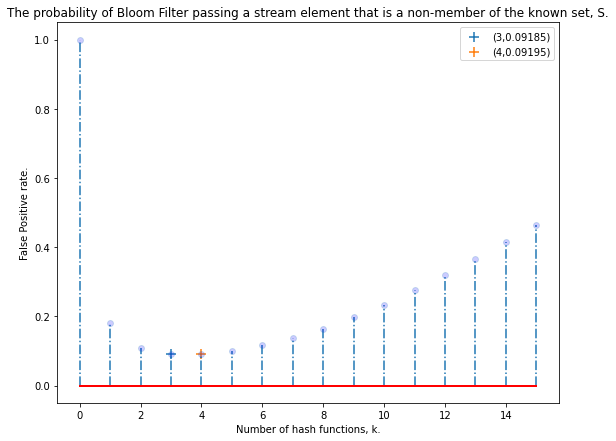

In [ ]:
import pylab as pl
# The graphical representation of the false positive rate of the Bloom filter.
fig = plt.figure(figsize=(9,7))

# k is an integer value.
kvalues = np.linspace(0,15,num = 16,endpoint = True)

markerline, stemlines, baseline = plt.stem(kvalues, FP_prob(m,n,kvalues), '-.')
pl.setp(markerline, 'markerfacecolor', 'b','alpha',0.2)
pl.setp(baseline, 'color','r', 'linewidth', 2)

for i,k in enumerate(Ks):
  plt.scatter(k,Ps[i],label =f"({k},{Ps[i]:.5f})",marker="+",s = 120)

#Show legend
plt.legend()
#Shoe axis labels
plt.xlabel('Number of hash functions, k.') 
plt.ylabel('False Positive rate.') 
# displaying the title
plt.title("The probability of Bloom Filter passing a stream element that is a non-member of the known set, S.")
plt.show()


The graph suggests that the False Positive rate has an optimum number of hash functions. This optimal value is estimated by the value of $x$ that gives a minimum stationary point for the continuous function of $f(x) = (1-e^{-mx/n})^x$, where $x \in R$. 

This can be determined by taking the logarithm of both sides and then finding the derivative function.

$log(f(x))=log[(1-e^{-mx/n})^x]$ 

$log(f(x))=xlog(1-e^{-mx/n})$

${d\over dx}log(f(x))={d\over dx}xlog(1-e^{-mx/n})$

${f'(x)\over f(x)}=log(1-e^{-mx/n})+x{{m\over n}e^{-mx/n}\over 1-e^{-mx/n}}$

Let  $y=e^{-mx/n}$ and so ${mx\over n}=-log(y)$

then  ${f'(x)\over f(x)}=log(1-y)-log(y){y\over 1-y}$

A minimum stationary point in $f(x)$ is observed when its derivative $f'(x)$ is zero.
Therefore, $log(1-y)-log(y){y\over 1-y} = 0$

${(1-y)log(1-y)-ylog(y)\over 1-y} = 0$

$(1-y)log(1-y)-ylog(y) = 0$

$log(1-y)-y(log(1-y)+log(y)) = 0$

$log(1-y)=ylog({y-y^2}) $

$1-y=({y-y^2})^y $

This is satisfied when $y = {1\over 2}$

It follows that $e^{-mx/n}={1\over 2}$ 

and therefore the stationary point occurs when $x = {n\over m}log(2)$.
Therefore the approximate value of k that optimises the false positive rate is $k \approx {n\over m}log(2)$ rounded to the nearest integer of k.

In [ ]:
#The optimal k given by the rule to minimise the false postive rate as given above.
def optimalk(n,m):
  k = round(np.log(2)*n/m)
  return k

# optimal value of number of hash functions to minimise false positive rate.
print(f'The optimal number of hash functions is: {optimalk(n,m)}')

The optimal number of hash functions is: 3
